In [172]:
%config InlineBackend.figure_format = 'retina' 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from imblearn.over_sampling import RandomOverSampler 
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [173]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv",encoding='cp949').drop(["Date", "Holiday", "Seasons"], axis=1)

In [174]:
df.columns = dataset_cols

In [175]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [176]:
df.columns = ['bike_count','hour','temp','humidity','wind','visibility','dew_pt_temp','radiation','rain','snow','functional']

In [177]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [178]:
df['functional'] = (df['functional'] == 'Yes').astype(int)

In [179]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [180]:
df = df[df['hour'] == 12]
df = df.drop(['hour'],axis = 1)

In [181]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


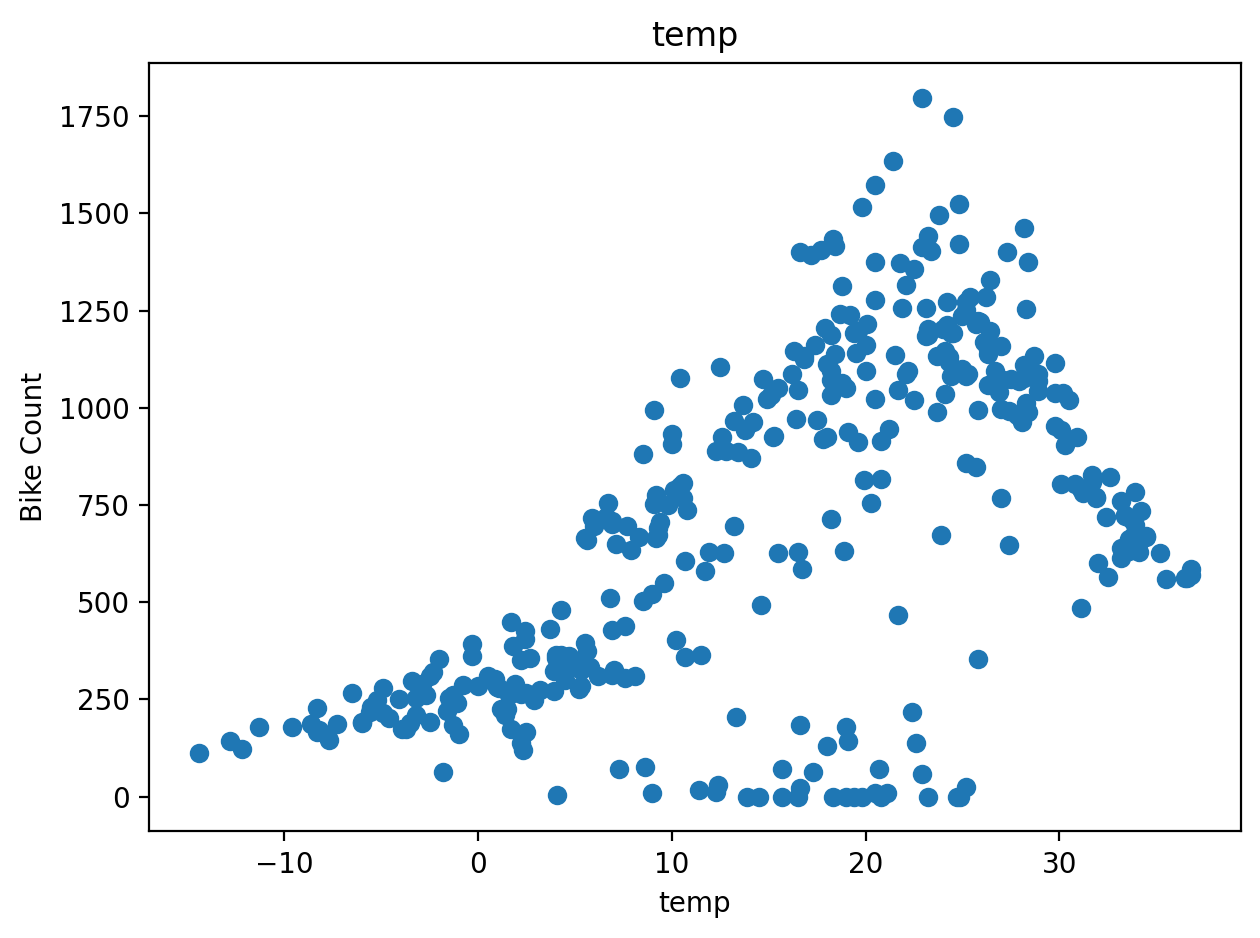

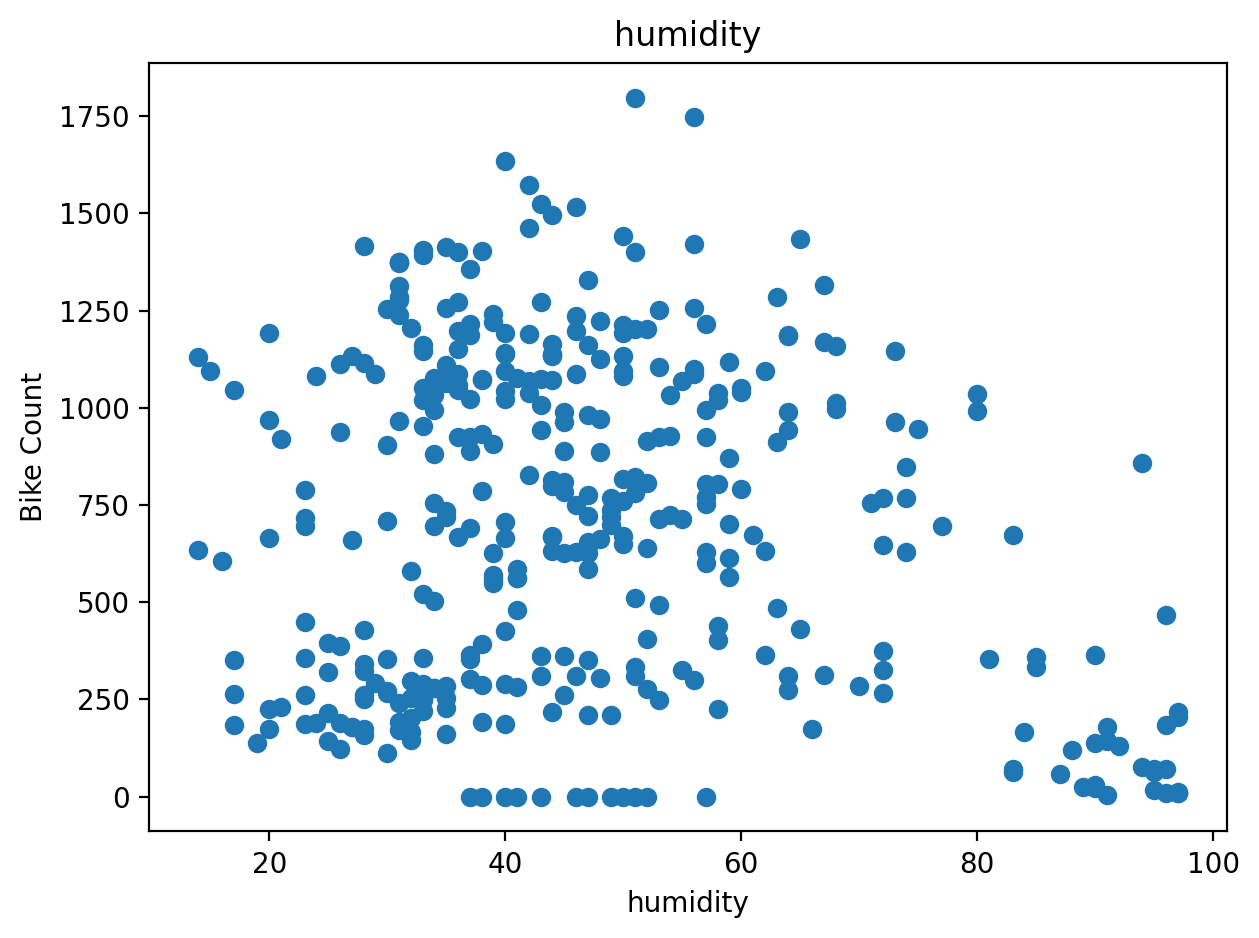

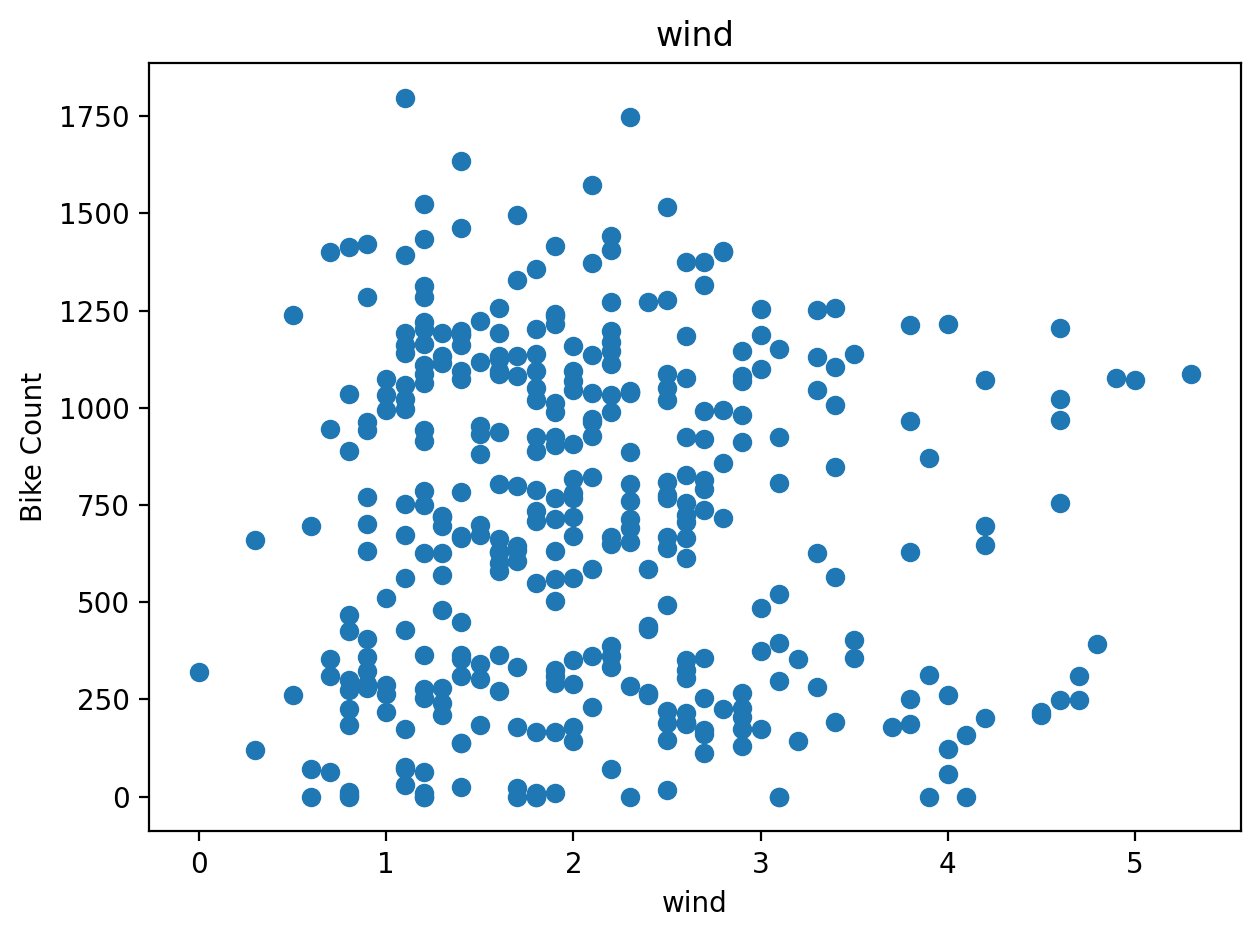

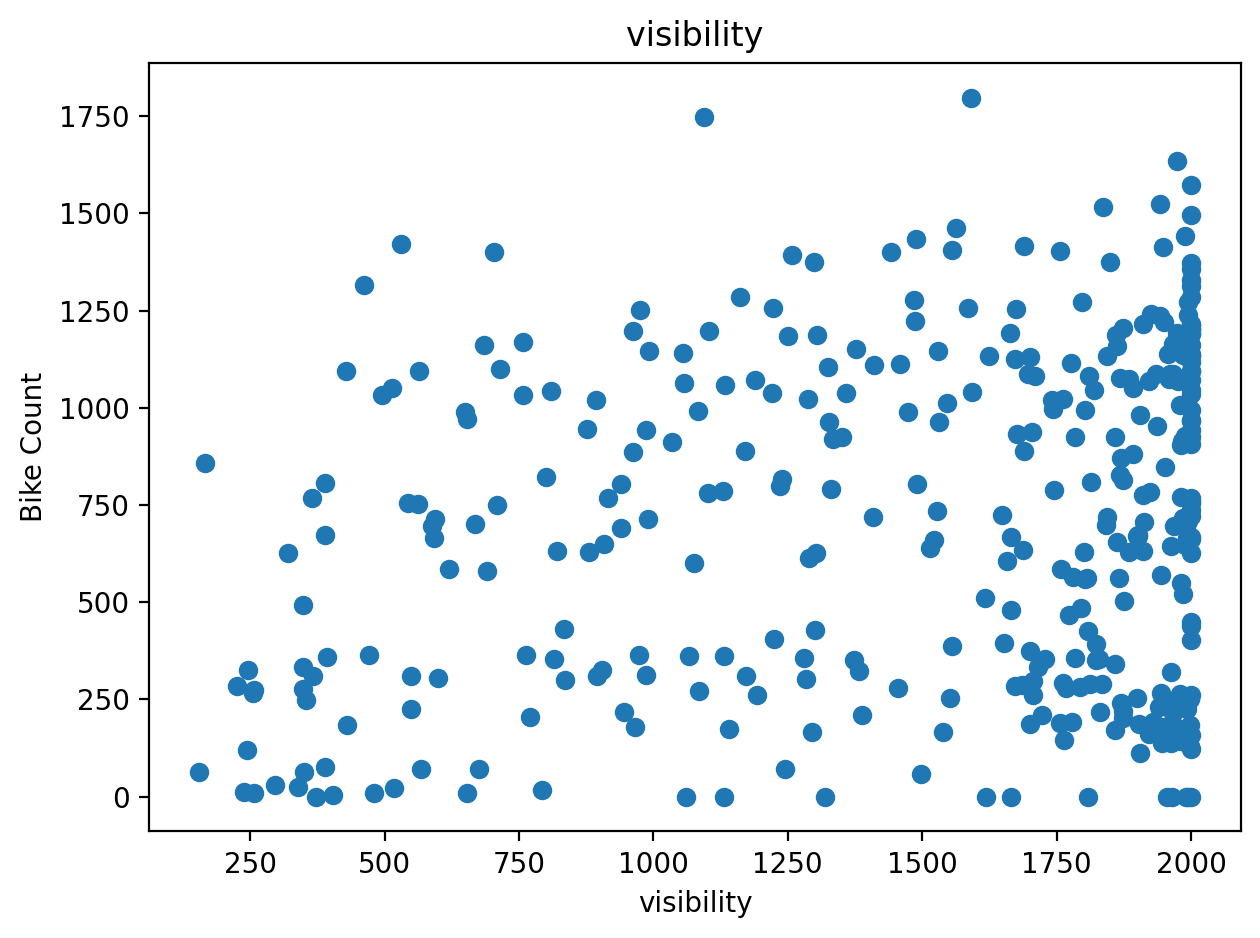

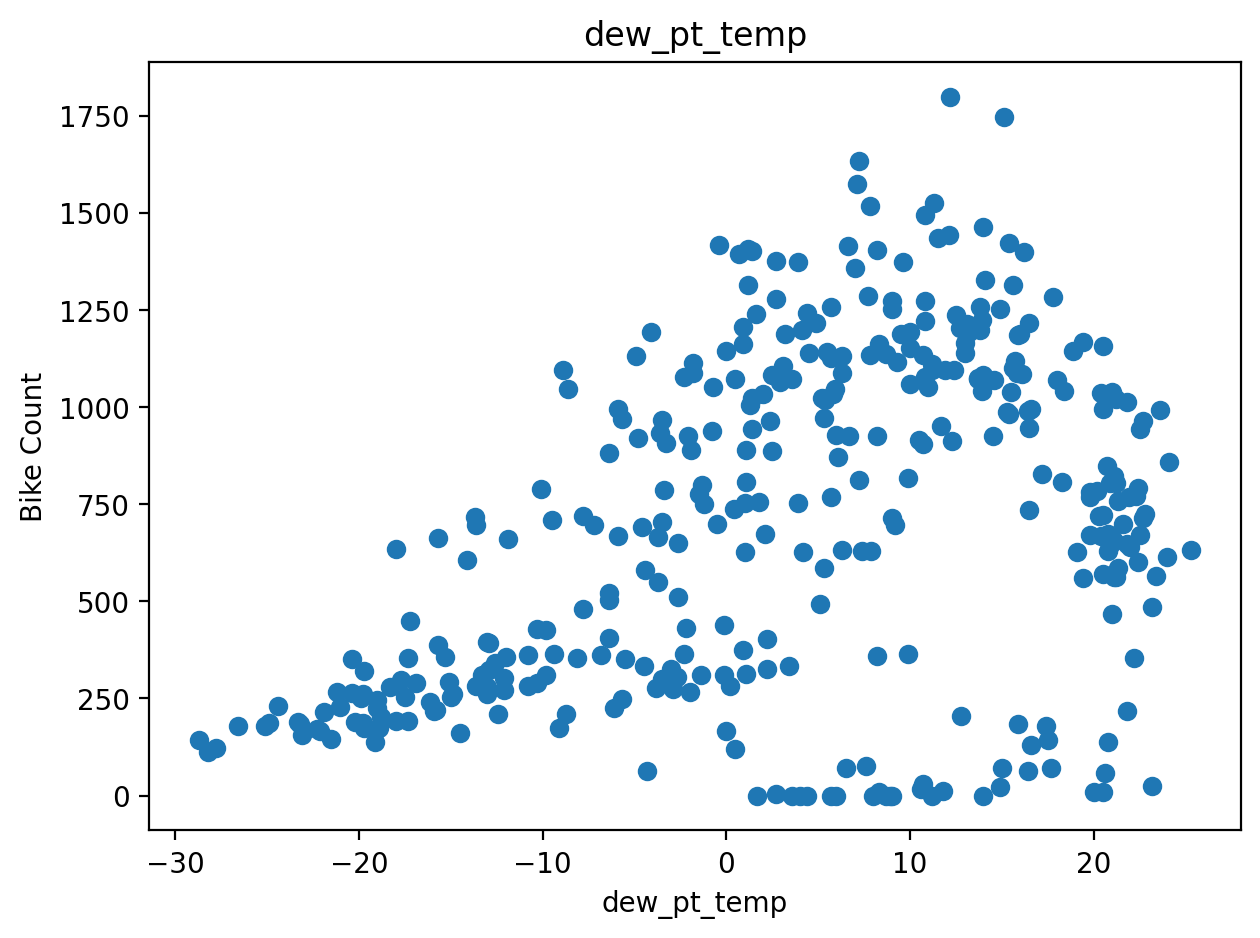

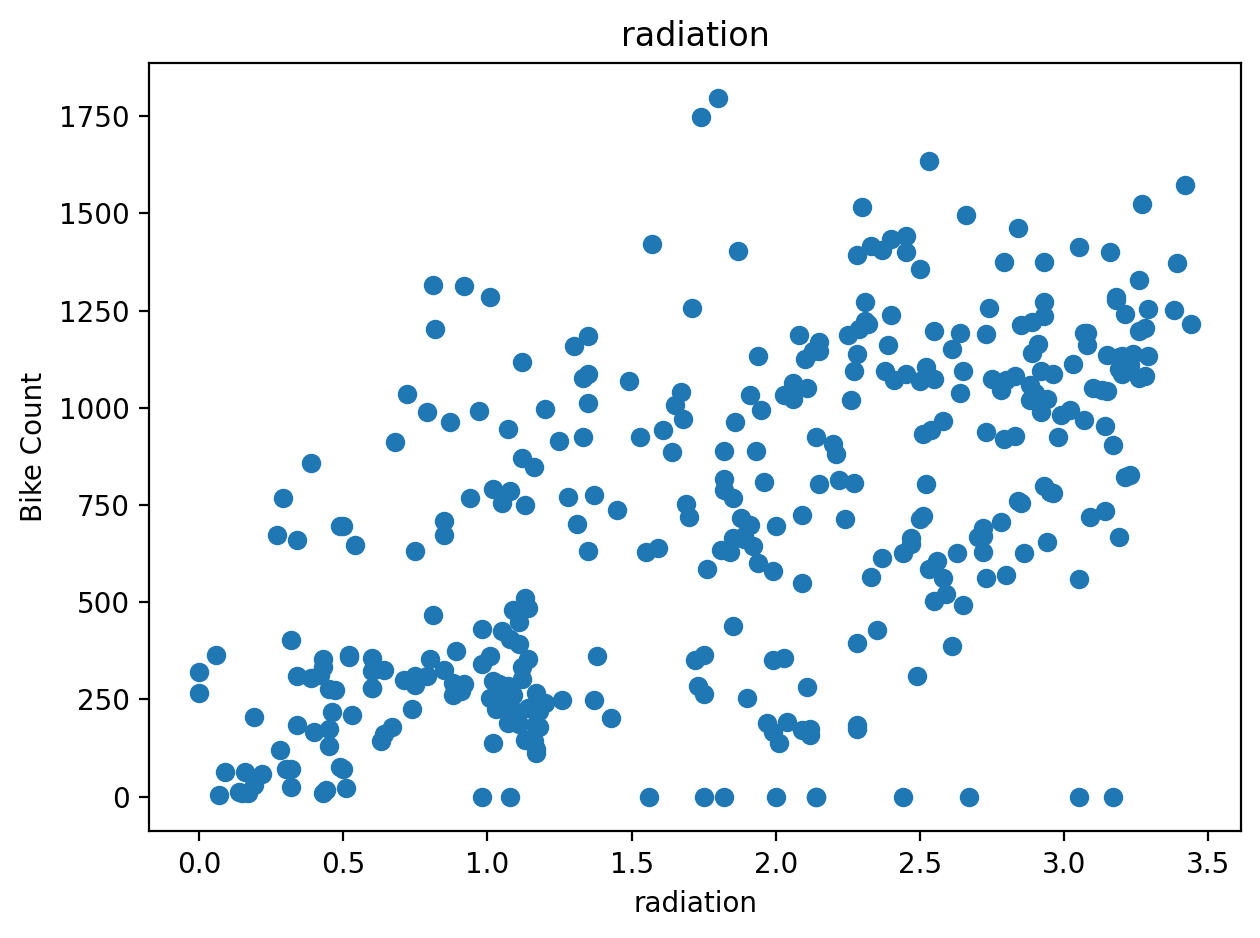

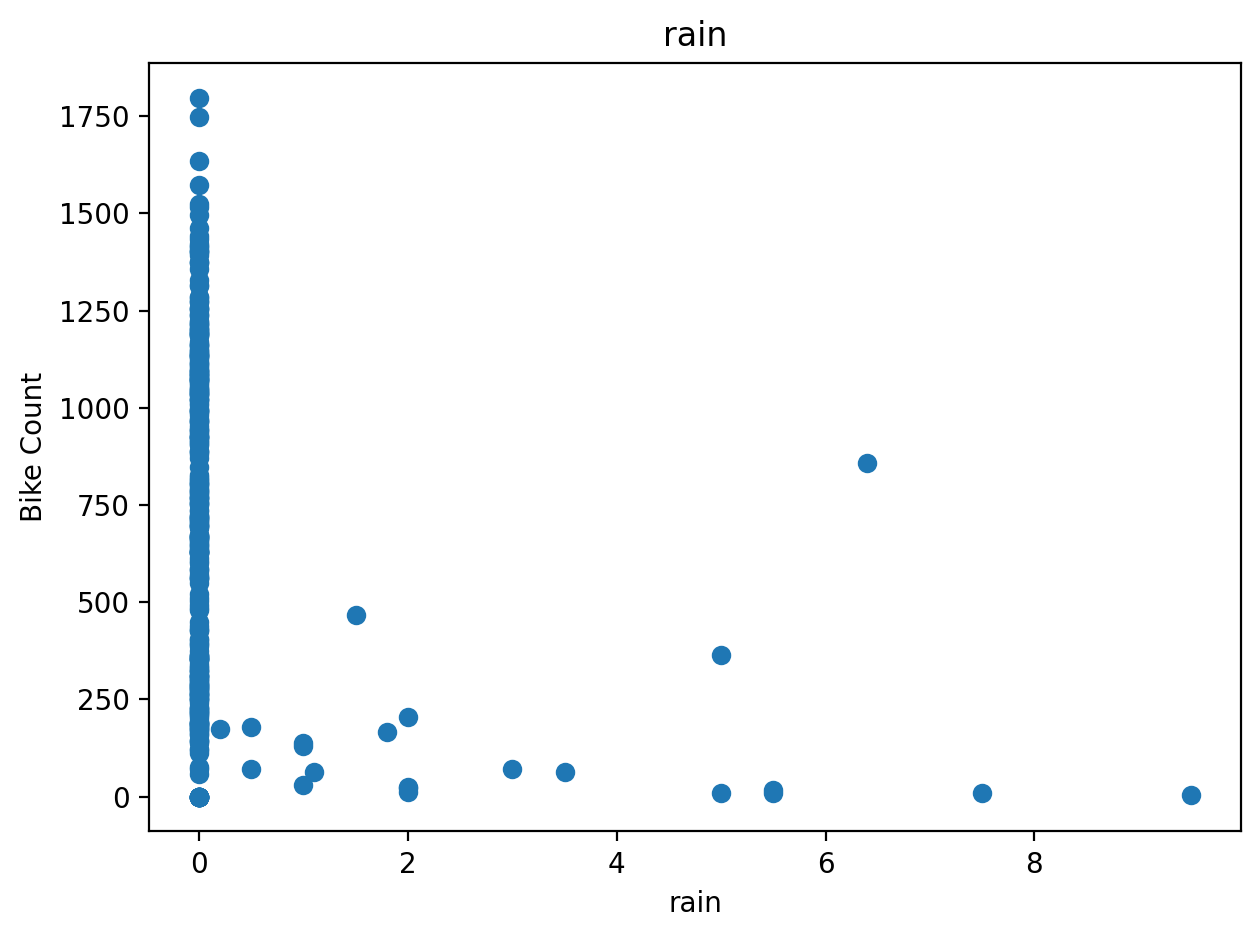

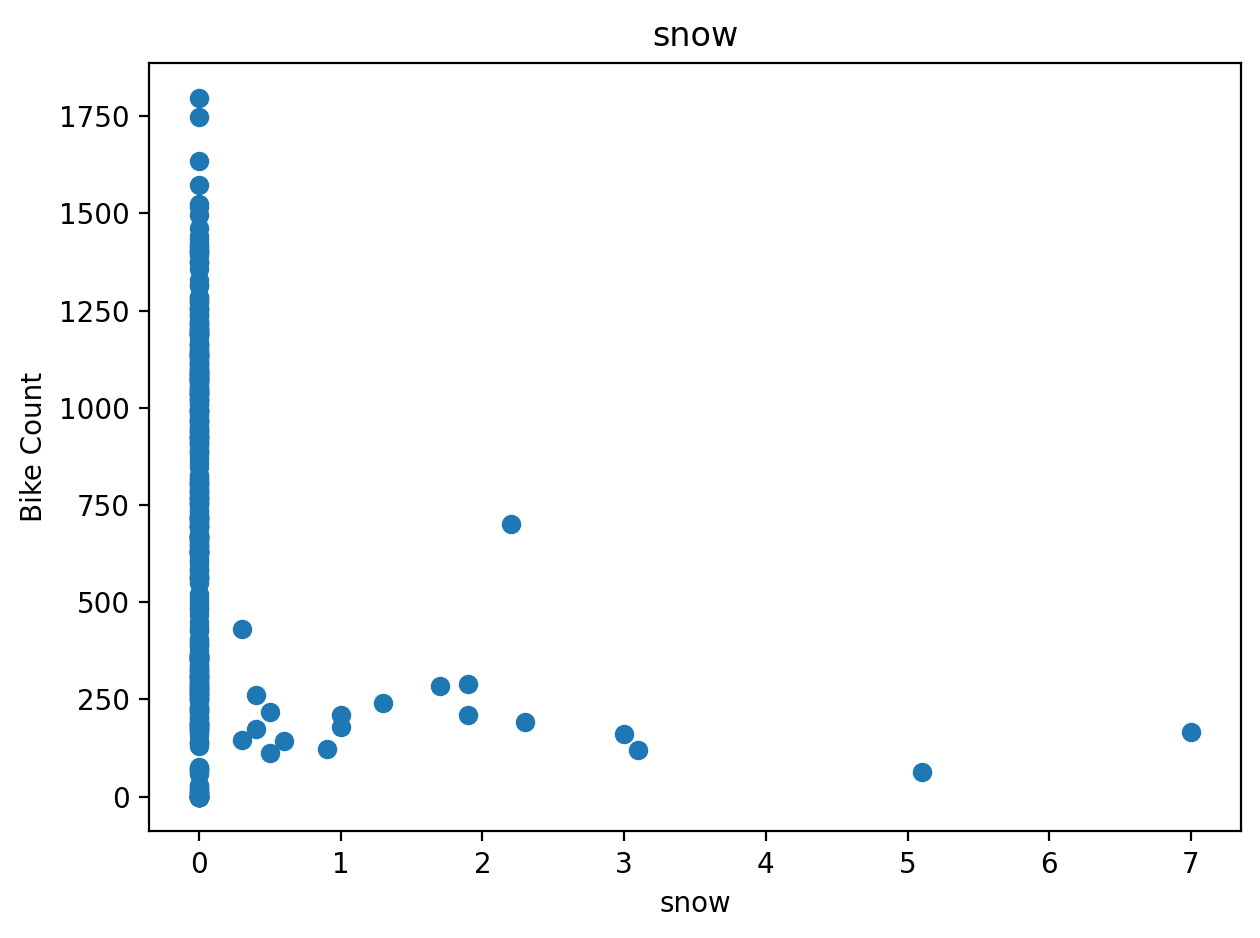

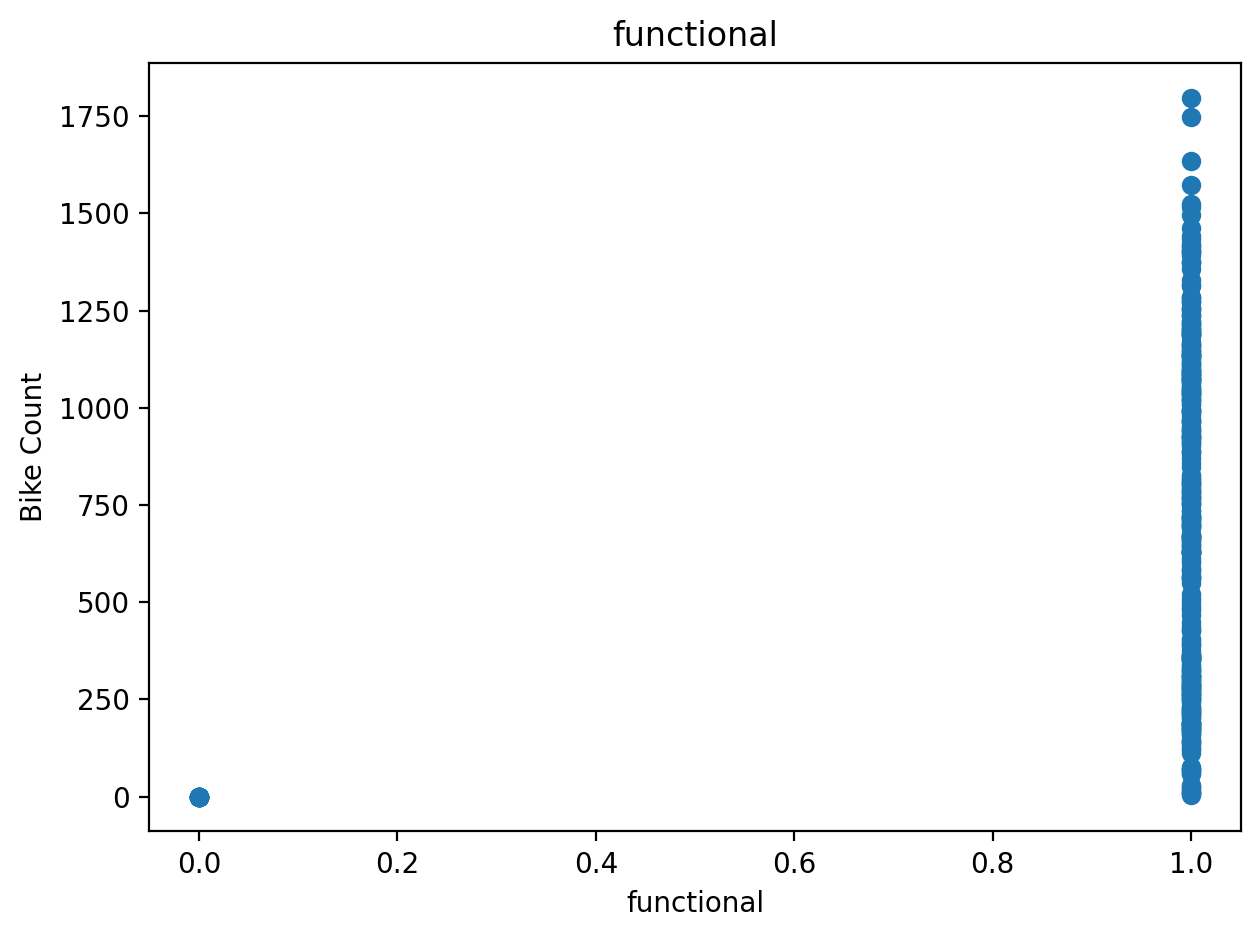

In [182]:
for label in df.columns[1:]:
    plt.scatter(df[label],df['bike_count'])
    plt.title(label)
    plt.ylabel("Bike Count")
    plt.xlabel(label)
    plt.tight_layout()
    plt.show()

In [183]:
df = df.drop(['wind','visibility','functional'],axis = 1)

In [184]:
df

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0
...,...,...,...,...,...,...,...
8652,752,9.1,57,1.0,1.69,0.0,0.0
8676,672,9.3,61,2.1,0.85,0.0,0.0
8700,635,7.9,14,-18.0,1.81,0.0,0.0
8724,661,5.6,27,-11.9,0.34,0.0,0.0


## Train/Valid/Test Dataset

In [222]:
# Shuffle the DataFrame
df_shuffled = df.sample(frac=1,random_state=69).reset_index(drop=True)
# Compute split indices
train_end = int(0.6 * len(df_shuffled))
val_end = int(0.8 * len(df_shuffled))

# Split using iloc
train = df_shuffled.iloc[:train_end]
val = df_shuffled.iloc[train_end:val_end]
test = df_shuffled.iloc[val_end:]

### df.sample(frac=1,random_state = 42).reset_index(drop = True): 
### This shuffles your original DataFrame (df) so that your train/validation/test sets are randomized.
- train_end = int(0.6 * len(df_shuffled))
- val_end = int(0.8 * len(df_shuffled))
- Train set: First 60% of the data
- Validation set: Next 20% (from 60% to 80%)
- Test set: Last 20% (from 80% to 100%)

In [223]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y


### Purpose: This function extracts the feature(s) (X) and the target (y) from your DataFrame.

### Parameters:

- dataframe: The DataFrame you want to extract data from.

- y_label: The name of the column you want to predict (the target variable).

- x_labels: The name(s) of the column(s) you want to use as features. If not given, it uses all columns except the target.

- How it works:

- It creates a deep copy of the DataFrame to avoid changing the original data.

- If x_labels is not provided, it uses all columns except the target as features.

- If only one feature is specified, it reshapes it to be a 2D array (required by scikit-learn).

- It extracts the target column and reshapes it.

- Returns: the combined data, the features (X), and the target (y).

In [224]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])


### Here, I'm extracting only the "temp" column as feature (X) and "bike_count" as target (y) for each of the train, validation, and test sets.

In [225]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)
# temp_reg = LineraRegression()

LinearRegression()

- LinearRegression(): This creates a linear regression model from scikit-learn.
- .fit(X_train_temp, y_train_temp): This trains (fits) the model using your training data.

In [226]:
temp_reg.score(X_test_temp, y_test_temp)

0.2857605431913096

- .score(): This evaluates the model's performance on the test set. By default, for regression, it returns the R² score (coefficient of determination), which tells you how well the model predicts the target.

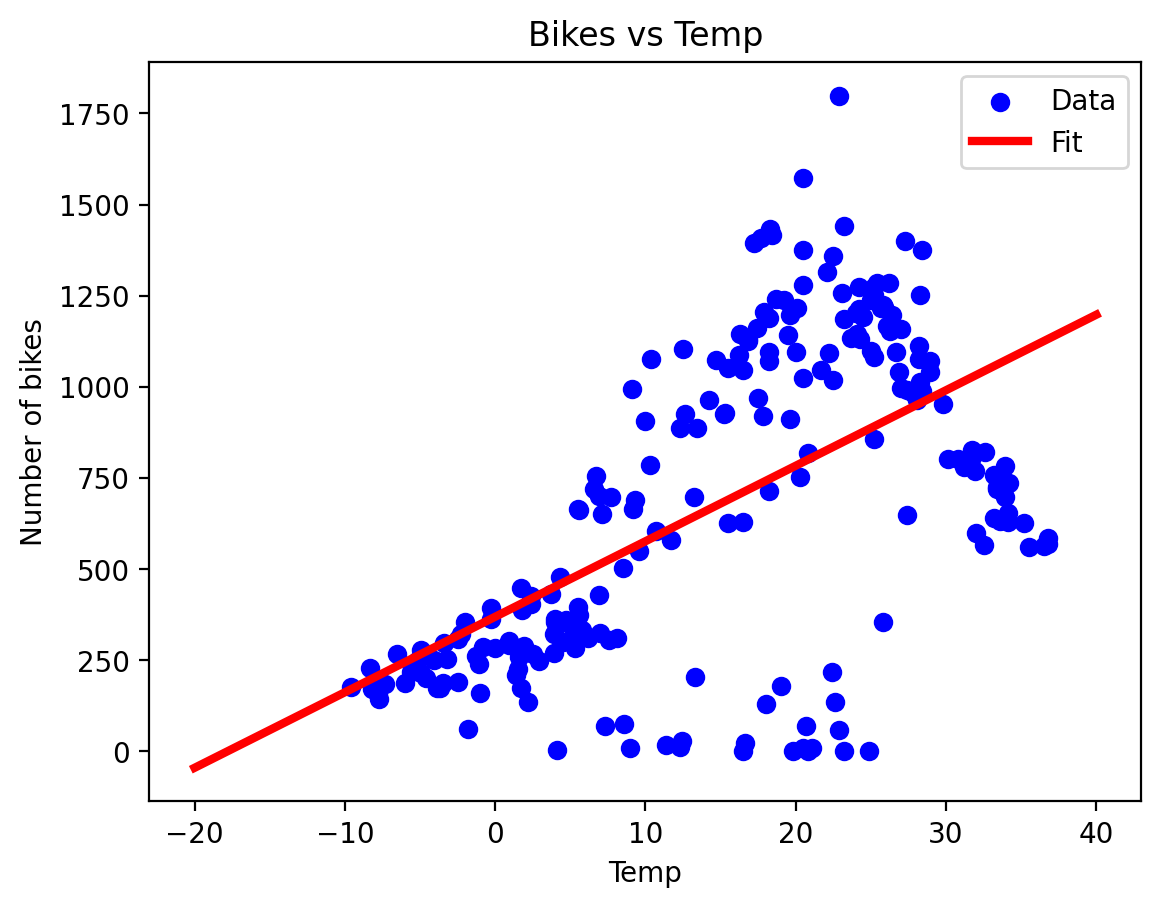

In [227]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Multiple Linear Regression

In [228]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [229]:
# Shuffle the DataFrame
df_shuffled = df.sample(frac=1,random_state=7).reset_index(drop=True)
# Compute split indices
train_end = int(0.6 * len(df_shuffled))
val_end = int(0.8 * len(df_shuffled))

# Split using iloc
train = df_shuffled.iloc[:train_end]
val = df_shuffled.iloc[train_end:val_end]
test = df_shuffled.iloc[val_end:]

_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [230]:
all_reg = LinearRegression()
all_reg.fit(X_train_all,y_train_all)

LinearRegression()

In [231]:
all_reg.score(X_test_all,y_test_all)

0.38586415674774976

In [211]:
y_pred_lr = all_reg.predict(X_test_all)